In [470]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from analytic_wfm.peakdetect import *

%run "Fonctions.ipynb"
%run "Signal.ipynb"

In [238]:
final_df = pd.DataFrame()
files = find_all_extension('../Millau/Resultats/', '.txt')
for elt in files:
    final_df = pd.concat([final_df, recover_sig(elt, ['A07'])], axis=1)

KeyboardInterrupt: 

In [ ]:
test = []
for elt in final_df.columns:
    if 'time' in elt:
        test.append(elt)
        
final_df[test].isnull().sum()[final_df[test].isnull().sum() == 0].index[0]

In [ ]:
2017-06-20-00-03-34-150
2017-06-20-00-03-41-144
2017-06-20-00-05-50-623
2017-06-20-00-05-57-142
2017-06-20-00-08-22-224
2017-06-20-00-33-07-871
2017-06-20-00-38-57-400
2017-06-20-00-39-22-968
2017-06-20-00-41-37-410
2017-06-20-00-45-20-611
2017-06-20-00-52-24-732
2017-06-20-00-54-50-955
2017-06-20-00-56-40-892
2017-06-20-00-57-12-093
2017-06-20-00-59-34-488

In [471]:
choix = '2017-06-20-00-38-57-400'

In [472]:
# Récupération des signaux
siwim_sig = list_multiple_var('A0', var_to=9) + list_multiple_var('A', 10, 21)
signaux = recover_sig('../Millau/Resultats\\2017-06-20-hh-mm-ss\\2017-06-20-00-mm-ss\\'+ choix +'.txt', siwim_sig)

In [473]:
# Calcul rapport signal à bruit (Plus c'est grand, mieux c'est !)
all_sig = pd.DataFrame()
for col in signaux.columns[1:]:
    df = pd.DataFrame([[col, signaux.loc[:,col].std()/signaux.loc[:int(0.3*len(signaux)),col].std()]], columns=["Name", "S/N"])
    all_sig = all_sig.append(df)
    
lis = all_sig.reset_index(drop=True).sort_values(by="S/N", ascending=False).iloc[[0],0].apply(lambda x: x.split('_')[0]).tolist()

In [474]:
signaux = recover_sig('../Millau/Resultats\\2017-06-20-hh-mm-ss\\2017-06-20-00-mm-ss\\'+ choix +'.txt', lis)

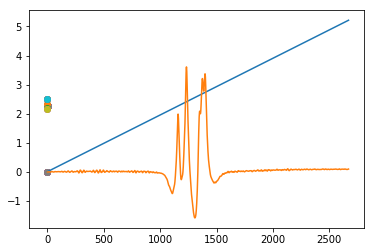

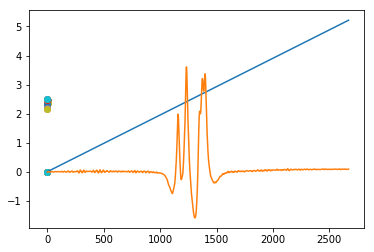

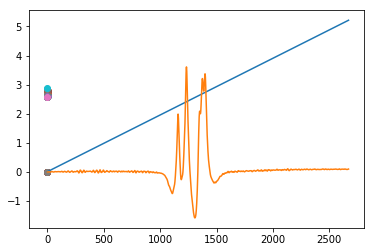

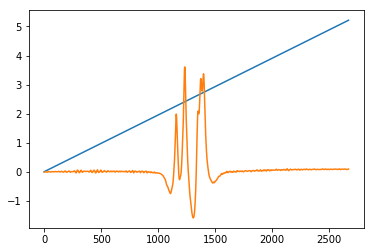

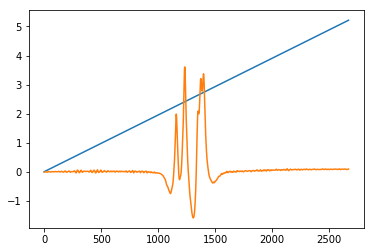

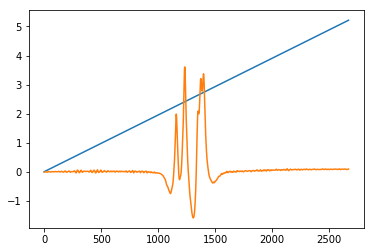

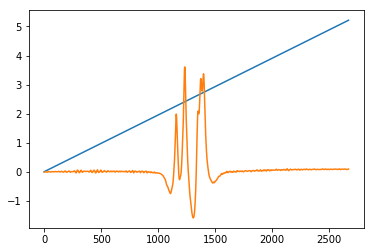

In [475]:
# Somme des signaux
signaux = somme_signaux(signaux)

# Supperposition des signaux
signaux = supperposition_signaux(signaux, 10)
signaux.columns = ['time', 'amplitude']
sig = Signal("Singal1", signaux, 20, 0.3)

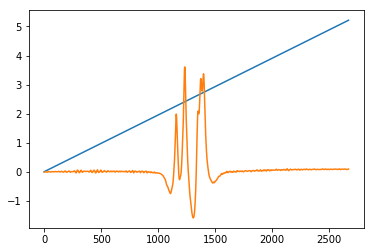

In [487]:
draw = sig.peaks[4].calculate__fwhm()

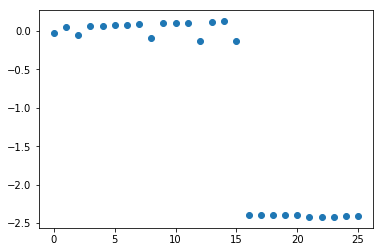

In [488]:
plt.scatter(draw.index, draw[0])

In [178]:
sig.peaks[0].fwhm

,0
0,0.00000
0,0.00390
0,0.00585
0,0.00977
0,0.01562
0,0.01953
0,0.02344
0,0.02734
0,0.03125
0,0.03516


TypeError: Could not compare [None] with block values

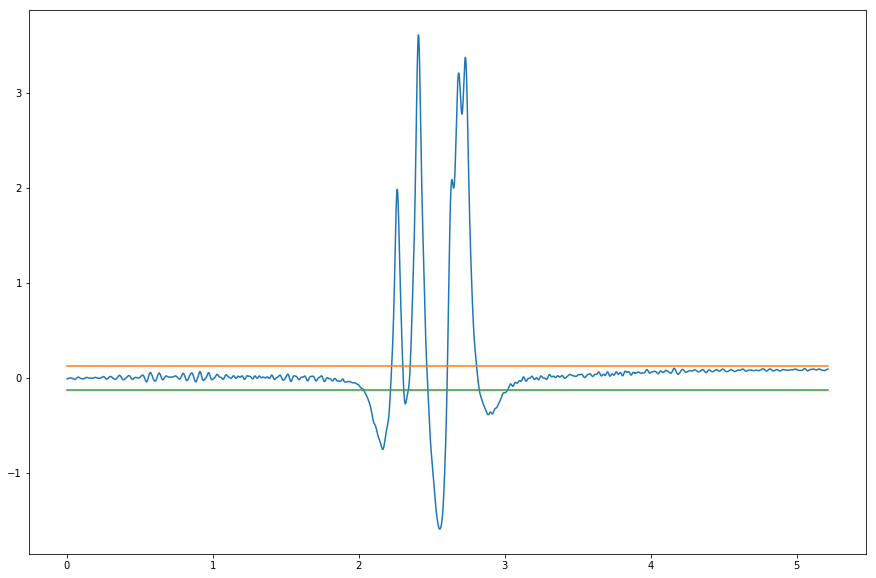

In [290]:
sig.show()

In [152]:
sig.to_df()

,time_0,amplitude_0,fwhm_0,time_1,amplitude_1,fwhm_1,time_2,amplitude_2,fwhm_2,time_3,amplitude_3,fwhm_3,time_4,amplitude_4,fwhm_4
0,2.50977,1.36087,0.05078,2.67578,2.143341,0.05664,2.98828,1.697158,0.14844,2.58984,0.17459,NaN,2.82031,-0.580492,NaN


#### Selection meilleur signal

In [301]:
signaux = supperposition_signaux(test)
pics = calcul_pics(signaux, 6, 0.05, 0.15)
best = best_courbe(signaux, pics)

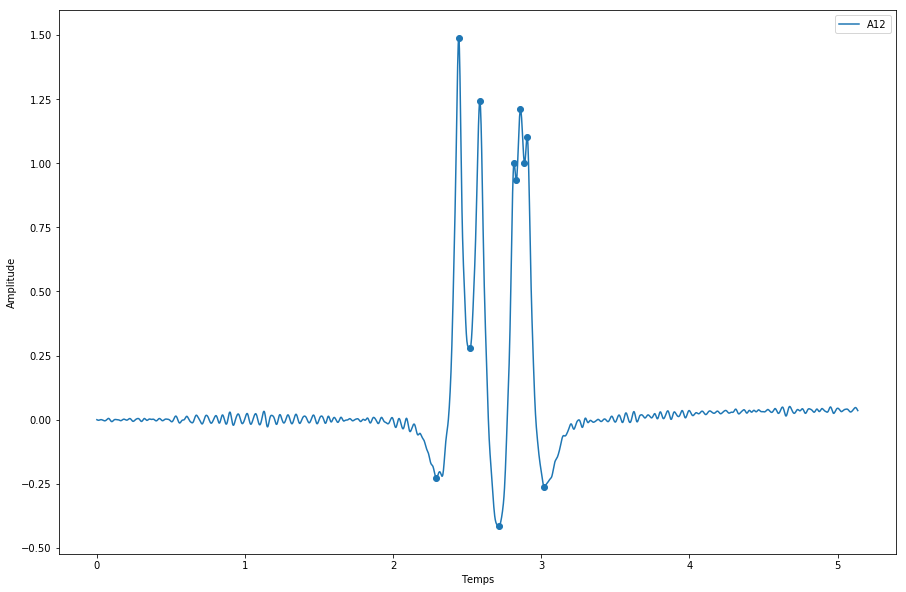

In [302]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(best[0].iloc[:, 0], best[0].iloc[:, 1])

# Detections des maximas et minimas
plt.scatter(best[1].iloc[:, 0], best[1].iloc[:, 1])

plt.legend([best[0].iloc[:,1].name])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

In [348]:
var_name = ['pos_min_', 'min_', 'pos_max_', 'max_']
var_list = []

for elt in var_name:
    if elt == var_name[0] or elt == var_name[1]:
        var_list.append(list_multiple_var(elt, 1, len(min_sig)))
    else:
        var_list.append(list_multiple_var(elt, 1, len(max_sig)))

In [361]:
pos_min = min_sig[[0]].T.reset_index(drop=True)
min_ampl = min_sig[[1]].T.reset_index(drop=True)
pos_max = max_sig[[0]].T.reset_index(drop=True)
max_ampl = max_sig[[1]].T.reset_index(drop=True)

pos_min.columns = var_list[0]
min_ampl.columns = var_list[1]
pos_max.columns = var_list[2]
max_ampl.columns = var_list[3]

In [371]:
pd.concat([,pos_min, min_ampl, pos_max, max_ampl], axis=1)

,pos_min_1,pos_min_2,pos_min_3,pos_min_4,pos_min_5,pos_min_6,min_1,min_2,min_3,min_4,...,pos_max_1,pos_max_2,pos_max_3,pos_max_4,pos_max_5,max_1,max_2,max_3,max_4,max_5
0,2.29102,2.51758,2.71289,2.83203,2.88672,3.02148,-0.22869,0.27787,-0.41501,0.9331,...,2.44336,2.58594,2.81641,2.85938,2.9043,1.48871,1.24161,1.00157,1.20993,1.10396


#### Somme signaux

In [285]:
test3['time'] = test.iloc[:,0]
test3['sig'] = test.iloc[:,1] + test.iloc[:,2] + test.iloc[:,3]

In [286]:
points = peakdetect(test3.iloc[:, 1],test3.iloc[:, 0], lookahead=5, delta=0.04)

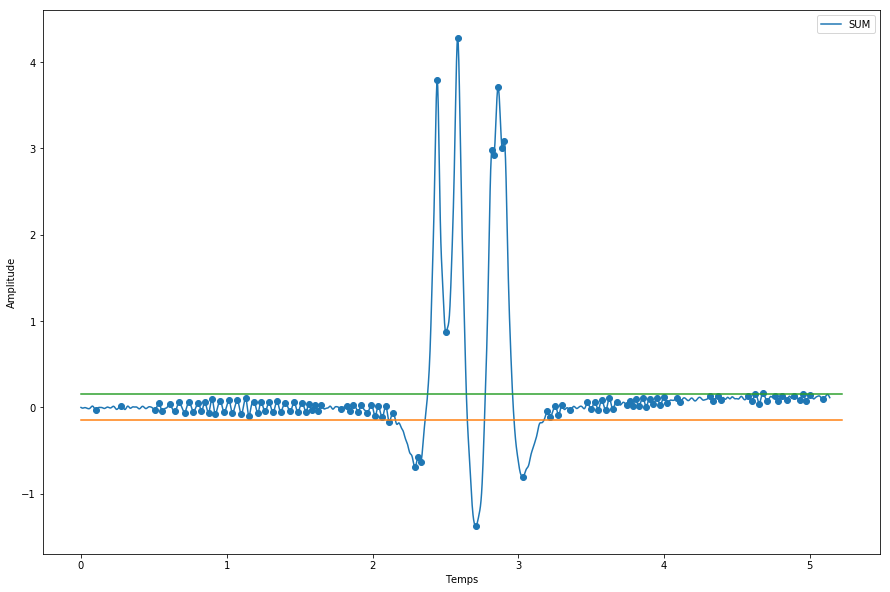

In [287]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(test3.iloc[:,0], test3.iloc[:, 1])

fourchette = 0.15
plt.plot([0, 5.22], [-fourchette, -fourchette])
plt.plot([0, 5.22], [fourchette, fourchette])

# Detections des maximas et minimas
plt.scatter(np.array(points[0] + points[1]).T[0], np.array(points[0] + points[1]).T[1])

plt.legend(['SUM'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()